In [9]:
!pip install linkpred

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for linkpred: filename=linkpred-0.5.1-py3-none-any.whl size=28742 sha256=639a579a9a4fd4c900b408b89eb06c2889e9e1c3247a0ce161636b67b6de506e
  Stored in directory: /root/.cache/pip/wheels/cc/24/15/4f18e6e3718786d97d74dd34e68744b063a338ca1fd677e055
  Created wheel for smokesignal: filename=smokesignal-0.7.0-py3-none-any.whl size=6030 sha256=2ce2d655a39c13e6a98d93ff2be7ca42d7c0151fd9fbde15b9aa63db532013d8
  Stored in directory: /root/.cache/pip/wheels/4b/b3/8e/a6eb57fab0fecdd37e8ffb5e602cde85ea095ed4d2d2f6c499
Successfully built linkpred smokesignal


In [10]:
import networkx as nx
import linkpred

In [11]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g


In [12]:
!wget https://andreafailla.github.io/uploads/data/got-s6-edges.csv

--2024-11-26 12:31:58--  https://andreafailla.github.io/uploads/data/got-s6-edges.csv
Resolving andreafailla.github.io (andreafailla.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to andreafailla.github.io (andreafailla.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10909 (11K) [text/csv]
Saving to: ‘got-s6-edges.csv.1’

got-s6-edges.csv.1  100%[===================>]  10.65K  --.-KB/s    in 0s      

2024-11-26 12:31:58 (66.5 MB/s) - ‘got-s6-edges.csv.1’ saved [10909/10909]



In [13]:
g = read_net_w('got-s6-edges.csv')

In [14]:
cn = linkpred.predictors.CommonNeighbours(g, excluded=g.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 8.0
NED - LADY_CRANE 8.0
NED - CLARENZO 8.0
MARGAERY - IZEMBARO 8.0
MARGAERY - ARYA 8.0


In [15]:
jc = linkpred.predictors.Jaccard(g, excluded=g.edges())
jc_results = jc.predict()

top = jc_results.top(5)
for edge, score in top.items():
    print(edge, score)

RED_PRIEST - KINVARA 1.0
LITTLE_SAM - DICKON 1.0
TOMMEN - MACE 0.7272727272727273
JOFFREY - CAMELLO 0.7272727272727273
OLD_NAN - BENJEN 0.7142857142857143


In [16]:
aa = linkpred.predictors.AdamicAdar(g, excluded=g.edges())
aa_results = aa.predict()

top = aa_results.top(5)
for edge, score in top.items():
    print(edge, score)

TOMMEN - MACE 3.1875572810307897
NED - LADY_CRANE 3.126371165725783
NED - CLARENZO 3.126371165725783
SANSA - ROBB 3.0966443151332466
JOFFREY - CAMELLO 2.8944937119329133


In [17]:
!wget https://andreafailla.github.io/uploads/data/got-s7-edges.csv

--2024-11-26 12:31:59--  https://andreafailla.github.io/uploads/data/got-s7-edges.csv
Resolving andreafailla.github.io (andreafailla.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to andreafailla.github.io (andreafailla.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7714 (7.5K) [text/csv]
Saving to: ‘got-s7-edges.csv’

got-s7-edges.csv    100%[===================>]   7.53K  --.-KB/s    in 0s      

2024-11-26 12:31:59 (57.3 MB/s) - ‘got-s7-edges.csv’ saved [7714/7714]



In [18]:
import random
import itertools
from linkpred.evaluation import Pair

# Building the test network
test = read_net_w(f'got-s7-edges.csv')

# Exclude test network from learning phase
training = g.copy()

# Node set
nodes = list(g.nodes())
nodes.extend(list(test.nodes()))

# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])

In [19]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)


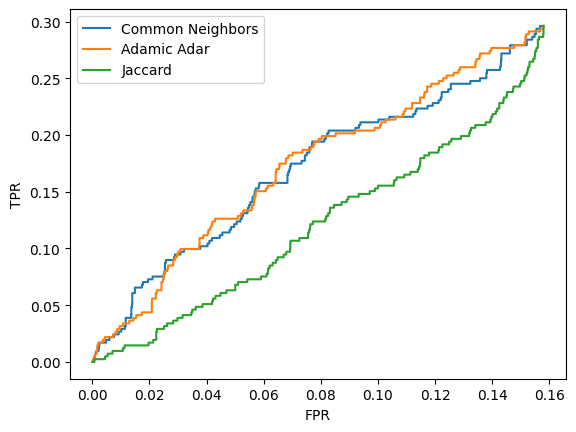

In [20]:
import matplotlib.pyplot as plt
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import auc

print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")

Area Under Roc Curve (AUROC)
Common Neigh.: 	 0.026832485313825823
Adamic Adar: 	 0.02725882588922178
Jaccard: 	 0.018894838921578106


In [22]:
for e, s in cn_results.items():
  print(e.elements)
  break

('JON', 'ARYA')


In [41]:
cn = linkpred.predictors.CommonNeighbours(g, excluded=g.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()
jc = linkpred.predictors.Jaccard(g, excluded=g.edges())
jc_results = jc.predict()
aa = linkpred.predictors.AdamicAdar(g, excluded=g.edges())
aa_results = aa.predict()

In [60]:
from collections import defaultdict
universe = list(set([Pair(i) for i in itertools.product(g.nodes(), g.nodes()) if i[0]!=i[1]]))


predictors = {
    'jaccard':  {tuple(sorted(pair.elements)): score for pair, score in  Jaccard(g).predict().items()},
    'adamic_adar': {tuple(sorted(pair.elements)): score for pair, score in  AdamicAdar(g).predict().items()},
    'cn': {tuple(sorted(pair.elements)): score for pair, score in  CommonNeighbours(g).predict().items()},
}


label = []

edge_data = defaultdict(dict)

for e in universe:
  e = tuple(sorted(e.elements))

  for k, v in predictors.items():
    edge_data[e][k] = v[e] if e in v else 0

  if e in g.edges():
    edge_data[e]['label'] = 1
  else:
    edge_data[e]['label'] = 0








In [61]:
import pandas as pd
df = pd.DataFrame(edge_data).T

In [62]:
df

,,jaccard,adamic_adar,cn,label
DOM,ROBETT,0.000000,0.000000,0.0,0.0
JEOR,ROBIN,0.000000,0.000000,0.0,0.0
LORAS,MELESSA,0.000000,0.000000,0.0,0.0
ARTHUR_CHILD,NYMERIA,0.000000,0.000000,0.0,0.0
DAARIO,LITTLEFINGER,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...
DAVOS,OBERYN,0.000000,0.000000,0.0,0.0
EDDISON_TOLLETT,OLLY,0.538462,2.745382,7.0,1.0
QYBURN,RICKON,0.000000,0.000000,0.0,0.0
DAVOS,KEVAN,0.000000,0.000000,0.0,0.0


In [63]:
# Calculate closeness centrality for all nodes
closeness_centrality = nx.closeness_centrality(g)

# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(g)

# Add new columns to the DataFrame
df['closeness_diff'] = df.index.map(lambda x: abs(closeness_centrality[x[0]] - closeness_centrality[x[1]]))
df['betweenness_diff'] = df.index.map(lambda x: abs(betweenness_centrality[x[0]] - betweenness_centrality[x[1]]))

df

,,jaccard,adamic_adar,cn,label,closeness_diff,betweenness_diff
DOM,ROBETT,0.000000,0.000000,0.0,0.0,0.088522,0.000687
JEOR,ROBIN,0.000000,0.000000,0.0,0.0,0.029387,0.000000
LORAS,MELESSA,0.000000,0.000000,0.0,0.0,0.080100,0.000412
ARTHUR_CHILD,NYMERIA,0.000000,0.000000,0.0,0.0,0.002351,0.006636
DAARIO,LITTLEFINGER,0.000000,0.000000,0.0,0.0,0.100522,0.002910
...,...,...,...,...,...,...,...
DAVOS,OBERYN,0.000000,0.000000,0.0,0.0,0.171413,0.023023
EDDISON_TOLLETT,OLLY,0.538462,2.745382,7.0,1.0,0.048105,0.004207
QYBURN,RICKON,0.000000,0.000000,0.0,0.0,0.040521,0.012456
DAVOS,KEVAN,0.000000,0.000000,0.0,0.0,0.052403,0.022392


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data into features (X) and labels (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # You can adjust hyperparameters
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1909
         1.0       0.88      0.68      0.77        94

    accuracy                           0.98      2003
   macro avg       0.93      0.84      0.88      2003
weighted avg       0.98      0.98      0.98      2003



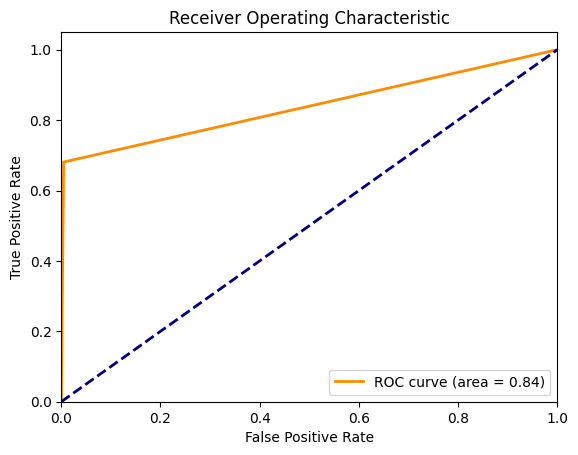

In [66]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred) #y_pred_prob
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
#

('SANSA', 'JON')